In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, precision_recall_curve, auc, roc_curve, classification_report, accuracy_score
from tabulate import tabulate
import joblib


In [2]:
RANDOM_SEED = 42

os.environ['PYTHONHASHSEED']=str(RANDOM_SEED)

random.seed(RANDOM_SEED)

np.random.seed(RANDOM_SEED)

In [3]:
mitbih_train = pd.read_csv('mitbih_train.csv', header=None)
mitbih_test = pd.read_csv('mitbih_test.csv', header=None)

# Variáveis para treino
X_train = mitbih_train.iloc[:, :-1].values
y_train = mitbih_train.iloc[:, -1].values

# Variáveis para teste e validação (50% teste - 50% validação)
X_test, X_val, y_test, y_val = train_test_split(mitbih_test.iloc[:, :-1].values,
                                                mitbih_test.iloc[:, -1].values,
                                                test_size=0.5,
                                                random_state=RANDOM_SEED)

#X_test = mitbih_test.iloc[:, :-1].values
#y_test = mitbih_test.iloc[:, -1].values

In [4]:
def print_avg_and_mean(dict):
    # Ponderado
    weighted_avg_precision = dict['weighted avg']['precision']
    weighted_avg_recall = dict['weighted avg']['recall']
    weighted_avg_f1_score = dict['weighted avg']['f1-score']
    weighted_avg_support = dict['weighted avg']['support']

    # Aritmético
    mean_precision = np.mean([dict[label]["precision"] for label in dict.keys() if label != "accuracy"])
    mean_recall = np.mean([dict[label]["recall"] for label in dict.keys() if label != "accuracy"]
    )
    mean_f1_score = np.mean([dict[label]["f1-score"] for label in dict.keys() if label != "accuracy"])
    mean_support = np.mean([dict[label]["support"] for label in dict.keys() if label != "accuracy"])

    print(f'Média Ponderada - Precisão: {weighted_avg_precision}')
    print(f'Média Ponderada - Recall: {weighted_avg_recall}')
    print(f'Média Ponderada - F1-Score: {weighted_avg_f1_score}')
    print(f'Média Ponderada - Support: {weighted_avg_support}')
    print('--------------------------------------------------')
    print(f'Média Aritmética - Precisão: {mean_precision}')
    print(f'Média Aritmética - Recall: {mean_recall}')
    print(f'Média Aritmética - F1-Score: {mean_f1_score}')
    print(f'Média Aritmética - Support: {mean_support}')

Treino: 87554
Teste:  10946
Total: 98500


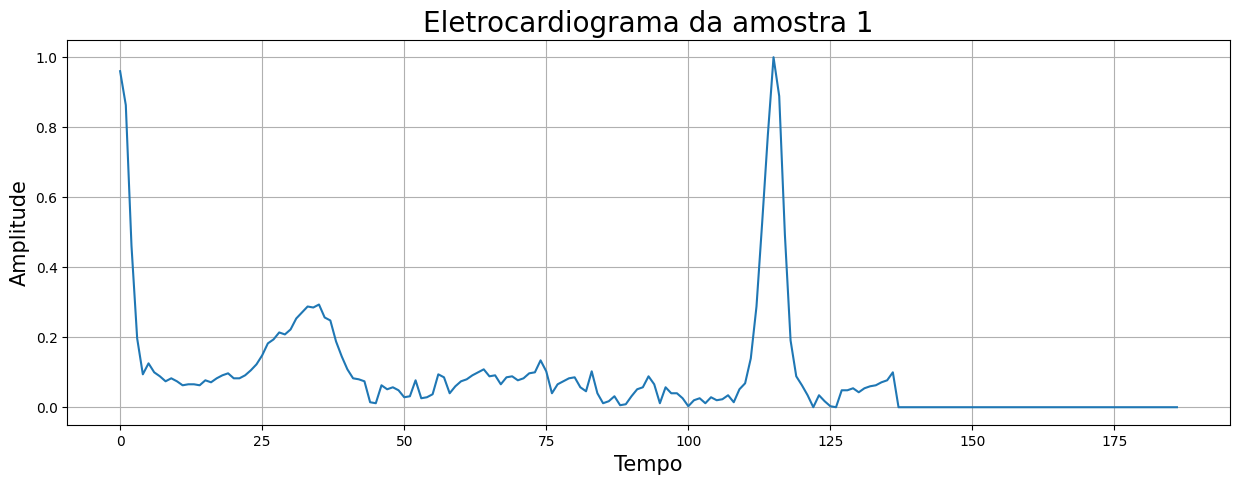

[0. 1. 2. 3. 4.]


In [5]:
index = 1
ecg_sample = X_train[index]
print('Treino:', len(X_train))
print("Teste: ", len(X_test))
print('Total:', len(X_train) + len(X_test))

plt.figure(figsize=(15, 5))
plt.plot(ecg_sample)
plt.title(f'Eletrocardiograma da amostra {index}', fontsize=20)
plt.xlabel('Tempo', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.grid(True)
plt.show()
print(np.unique(y_train))

In [6]:

print(f"Treino: {mitbih_train.shape}")
print(f"Test: {mitbih_test.shape}")
print("-----------------")
print(f"Treino (X):", {X_train.shape})
print(f"Treino (y):", {y_train.shape})
print(f"Teste (X):", {X_test.shape})
print(f"Teste (y):", {y_test.shape})
print(f"Validação (X):", {X_val.shape})
print(f"Validação (y):", {y_val.shape})

Treino: (87554, 188)
Test: (21892, 188)
-----------------
Treino (X): {(87554, 187)}
Treino (y): {(87554,)}
Teste (X): {(10946, 187)}
Teste (y): {(10946,)}
Validação (X): {(10946, 187)}
Validação (y): {(10946,)}


# Valores padrões

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

y_val_pred = knn.predict(X_val_scaled)
classification_report_val = classification_report(y_val, y_val_pred, output_dict=True)

y_test_pred = knn.predict(X_test_scaled)
classification_report_test = classification_report(y_test, y_test_pred, output_dict=True)

print("Relatório de Classificação - Validação (KNN)")
print(classification_report(y_val, y_val_pred))

print("Relatório de Classificação - Teste (KNN)")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
specificities_test = []
for i in range(len(cm_test)):
    TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
    FP = np.sum(cm_test[:, i]) - cm_test[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_test.append(specificity)

specificity_mean_test = np.mean(specificities_test)
print(f"Especificidade Média do KNN (Teste): {specificity_mean_test:.4f}")

cm_val = confusion_matrix(y_val, y_val_pred)
specificities_val = []
for i in range(len(cm_val)):
    TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
    FP = np.sum(cm_val[:, i]) - cm_val[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_val.append(specificity)

specificity_mean_val = np.mean(specificities_val)
print(f"Especificidade Média do KNN (Validação): {specificity_mean_val:.4f}")


Relatório de Classificação - Validação (KNN)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9106
         1.0       0.88      0.66      0.75       267
         2.0       0.91      0.89      0.90       694
         3.0       0.73      0.58      0.65        84
         4.0       0.99      0.95      0.97       795

    accuracy                           0.97     10946
   macro avg       0.90      0.82      0.85     10946
weighted avg       0.97      0.97      0.97     10946

Relatório de Classificação - Teste (KNN)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9012
         1.0       0.90      0.62      0.74       289
         2.0       0.95      0.89      0.92       754
         3.0       0.80      0.71      0.75        78
         4.0       1.00      0.96      0.98       813

    accuracy                           0.97     10946
   macro avg       0.93      0.83      0.87  

# n_neighbors

In [14]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_SEED)

k_list = list(range(1, 50, 2))

val_scores = []

for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_split, y_train_split)

    val_score = knn.score(X_val_split, y_val_split)
    val_scores.append(val_score)

best_k = k_list[np.argmax(val_scores)]
print(f"Melhor valor de k encontrado: {best_k}")

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

y_val_pred = best_knn.predict(X_val)
classification_report_val = classification_report(y_val, y_val_pred, output_dict=True)

y_test_pred = best_knn.predict(X_test)
classification_report_test = classification_report(y_test, y_test_pred, output_dict=True)

print(f"Relatório de Classificação - Teste (KNN com n_neighbors={best_k})")
print(classification_report(y_test, y_test_pred))

print(f"Relatório de Classificação - Validação (KNN com n_neighbors={best_k})")
print(classification_report(y_val, y_val_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
specificities_test = []
for i in range(len(cm_test)):
    TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
    FP = np.sum(cm_test[:, i]) - cm_test[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_test.append(specificity)

specificity_mean_test = np.mean(specificities_test)
print(f"Especificidade Média do KNN (Teste) com n_neighbors={best_k}: {specificity_mean_test:.4f}")

cm_val = confusion_matrix(y_val, y_val_pred)
specificities_val = []
for i in range(len(cm_val)):
    TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
    FP = np.sum(cm_val[:, i]) - cm_val[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_val.append(specificity)

specificity_mean_val = np.mean(specificities_val)
print(f"Especificidade Média do KNN (Validação) com n_neighbors={best_k}: {specificity_mean_val:.4f}")


Melhor valor de k encontrado: 1
Relatório de Classificação - Teste (KNN com n_neighbors=1)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9012
         1.0       0.80      0.73      0.76       289
         2.0       0.95      0.92      0.94       754
         3.0       0.84      0.85      0.84        78
         4.0       0.99      0.97      0.98       813

    accuracy                           0.98     10946
   macro avg       0.91      0.89      0.90     10946
weighted avg       0.98      0.98      0.98     10946

Relatório de Classificação - Validação (KNN com n_neighbors=1)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9106
         1.0       0.83      0.74      0.78       267
         2.0       0.93      0.92      0.93       694
         3.0       0.70      0.62      0.66        84
         4.0       0.98      0.96      0.97       795

    accuracy                   

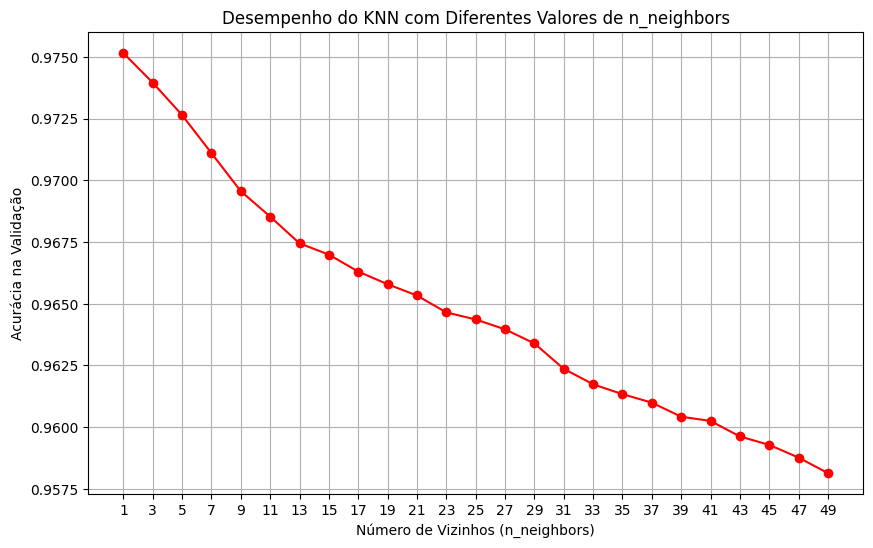

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(k_list, val_scores, marker='o', color='r')
plt.title('Desempenho do KNN com Diferentes Valores de n_neighbors')
plt.xlabel('Número de Vizinhos (n_neighbors)')
plt.ylabel('Acurácia na Validação')
plt.xticks(np.arange(1, 50, step=2))
plt.grid(True)
plt.show()


# weights
<ul>
<li>‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.</li>

<li>‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.</li>
</ul>

In [36]:
weights_list = ['uniform', 'distance']

best_weights = None
best_specificity_mean_test = 0
best_specificity_mean_val = 0
best_y_test_pred = None
best_y_val_pred = None

for weights in weights_list:
    knn = KNeighborsClassifier(n_neighbors=1, weights=weights)
    knn.fit(X_train, y_train)

    y_val_pred = knn.predict(X_val)

    y_test_pred = knn.predict(X_test)

    cm_test = confusion_matrix(y_test, y_test_pred)
    specificities_test = []
    for i in range(len(cm_test)):
        TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
        FP = np.sum(cm_test[:, i]) - cm_test[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_test.append(specificity)

    specificity_mean_test = np.mean(specificities_test)

    cm_val = confusion_matrix(y_val, y_val_pred)
    specificities_val = []
    for i in range(len(cm_val)):
        TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
        FP = np.sum(cm_val[:, i]) - cm_val[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_val.append(specificity)

    specificity_mean_val = np.mean(specificities_val)

    if specificity_mean_test > best_specificity_mean_test:
        best_specificity_mean_test = specificity_mean_test
        best_specificity_mean_val = specificity_mean_val
        best_weights = weights
        best_y_test_pred = y_test_pred
        best_y_val_pred = y_val_pred

print(f"Melhor valor de weights encontrado: {best_weights}")

print("\nRelatório de Classificação - Teste (Melhor Modelo)")
print(classification_report(y_test, best_y_test_pred))

print("\nRelatório de Classificação - Validação (Melhor Modelo)")
print(classification_report(y_val, best_y_val_pred))

print(f"Especificidade Média do Melhor Modelo no Teste: {best_specificity_mean_test:.4f}")
print(f"Especificidade Média do Melhor Modelo na Validação: {best_specificity_mean_val:.4f}")

Melhor valor de weights encontrado: uniform

Relatório de Classificação - Teste (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9012
         1.0       0.80      0.73      0.76       289
         2.0       0.95      0.92      0.94       754
         3.0       0.84      0.85      0.84        78
         4.0       0.99      0.97      0.98       813

    accuracy                           0.98     10946
   macro avg       0.91      0.89      0.90     10946
weighted avg       0.98      0.98      0.98     10946


Relatório de Classificação - Validação (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9106
         1.0       0.83      0.74      0.78       267
         2.0       0.93      0.92      0.93       694
         3.0       0.70      0.62      0.66        84
         4.0       0.98      0.96      0.97       795

    accuracy                     

# algorithm : {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
### <ul> 
<li>‘ball_tree’ will use BallTree</li>

<li> ‘kd_tree’ will use KDTree</li>

<li> ‘brute’ will use a brute-force search.</li>

<li> ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method. </li>
</ul>

In [37]:
algorithm_list = ['auto', 'ball_tree', 'kd_tree', 'brute']

best_algorithm = None
best_specificity_mean_test = 0
best_specificity_mean_val = 0
best_y_test_pred = None
best_y_val_pred = None

for algorithm in algorithm_list:
    knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm=algorithm)
    knn.fit(X_train, y_train)

    y_val_pred = knn.predict(X_val)

    y_test_pred = knn.predict(X_test)

    cm_test = confusion_matrix(y_test, y_test_pred)
    specificities_test = []
    for i in range(len(cm_test)):
        TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
        FP = np.sum(cm_test[:, i]) - cm_test[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_test.append(specificity)

    specificity_mean_test = np.mean(specificities_test)

    cm_val = confusion_matrix(y_val, y_val_pred)
    specificities_val = []
    for i in range(len(cm_val)):
        TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
        FP = np.sum(cm_val[:, i]) - cm_val[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_val.append(specificity)

    specificity_mean_val = np.mean(specificities_val)

    if specificity_mean_test > best_specificity_mean_test:
        best_specificity_mean_test = specificity_mean_test
        best_specificity_mean_val = specificity_mean_val
        best_algorithm = algorithm
        best_y_test_pred = y_test_pred
        best_y_val_pred = y_val_pred

print(f"Melhor valor de algorithm encontrado: {best_algorithm}")

print("\nRelatório de Classificação - Teste (Melhor Modelo)")
print(classification_report(y_test, best_y_test_pred))

print("\nRelatório de Classificação - Validação (Melhor Modelo)")
print(classification_report(y_val, best_y_val_pred))

print(f"Especificidade Média do Melhor Modelo no Teste: {best_specificity_mean_test:.4f}")
print(f"Especificidade Média do Melhor Modelo na Validação: {best_specificity_mean_val:.4f}")

Melhor valor de algorithm encontrado: auto

Relatório de Classificação - Teste (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9012
         1.0       0.80      0.73      0.76       289
         2.0       0.95      0.92      0.94       754
         3.0       0.84      0.85      0.84        78
         4.0       0.99      0.97      0.98       813

    accuracy                           0.98     10946
   macro avg       0.91      0.89      0.90     10946
weighted avg       0.98      0.98      0.98     10946


Relatório de Classificação - Validação (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9106
         1.0       0.83      0.74      0.78       267
         2.0       0.93      0.92      0.93       694
         3.0       0.70      0.62      0.66        84
         4.0       0.98      0.96      0.97       795

    accuracy                      

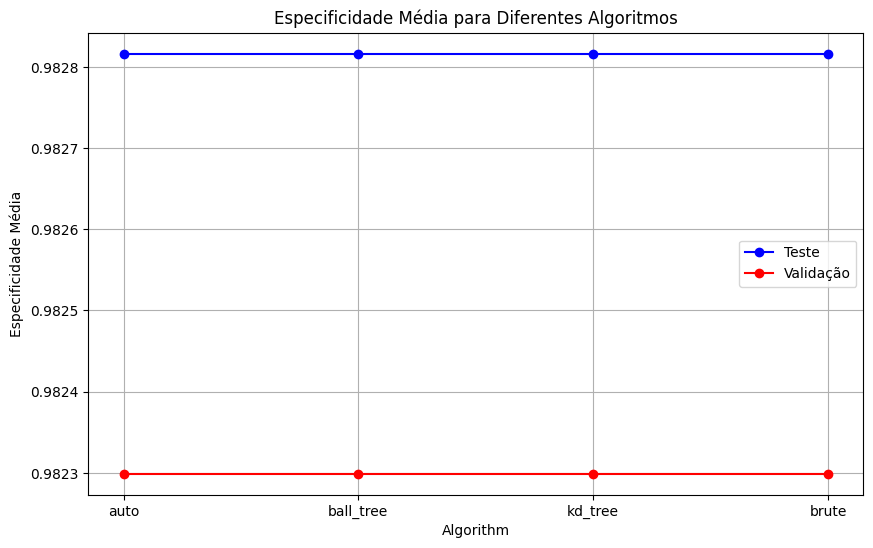

In [39]:
specificity_means_test = []
specificity_means_val = []

algorithm_list = ['auto', 'ball_tree', 'kd_tree', 'brute']

for algorithm in algorithm_list:
    specificity_means_test.append(specificity_mean_test)
    specificity_means_val.append(specificity_mean_val)

plt.figure(figsize=(10, 6))
plt.plot(algorithm_list, specificity_means_test, marker='o', linestyle='-', color='b', label='Teste')
plt.plot(algorithm_list, specificity_means_val, marker='o', linestyle='-', color='r', label='Validação')
plt.title('Especificidade Média para Diferentes Algoritmos')
plt.xlabel('Algorithm')
plt.ylabel('Especificidade Média')
plt.legend()
plt.grid(True)
plt.show()


# leaf_sizeint, default=30

Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.

In [46]:
leaf_size_list = range(1, 51)

specificity_means_test = []
specificity_means_val = []

best_leaf_size = None
best_specificity_mean_test = 0
best_specificity_mean_val = 0
best_y_test_pred = None
best_y_val_pred = None

for leaf_size in leaf_size_list:
    knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', leaf_size=leaf_size)
    knn.fit(X_train, y_train)

    y_val_pred = knn.predict(X_val)

    y_test_pred = knn.predict(X_test)

    cm_test = confusion_matrix(y_test, y_test_pred)
    specificities_test = []
    for i in range(len(cm_test)):
        TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
        FP = np.sum(cm_test[:, i]) - cm_test[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_test.append(specificity)

    specificity_mean_test = np.mean(specificities_test)
    specificity_means_test.append(specificity_mean_test)

    cm_val = confusion_matrix(y_val, y_val_pred)
    specificities_val = []
    for i in range(len(cm_val)):
        TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
        FP = np.sum(cm_val[:, i]) - cm_val[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_val.append(specificity)

    specificity_mean_val = np.mean(specificities_val)
    specificity_means_val.append(specificity_mean_val)

    if specificity_mean_test > best_specificity_mean_test:
        best_specificity_mean_test = specificity_mean_test
        best_specificity_mean_val = specificity_mean_val
        best_leaf_size = leaf_size
        best_y_test_pred = y_test_pred
        best_y_val_pred = y_val_pred

print(f"Melhor valor de leaf_size encontrado: {best_leaf_size}")

print("\nRelatório de Classificação - Teste (Melhor Modelo)")
print(classification_report(y_test, best_y_test_pred))

print("\nRelatório de Classificação - Validação (Melhor Modelo)")
print(classification_report(y_val, best_y_val_pred))

print(f"Especificidade Média do Melhor Modelo no Teste: {best_specificity_mean_test:.4f}")
print(f"Especificidade Média do Melhor Modelo na Validação: {best_specificity_mean_val:.4f}")

Melhor valor de leaf_size encontrado: 1

Relatório de Classificação - Teste (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9012
         1.0       0.80      0.73      0.76       289
         2.0       0.95      0.92      0.94       754
         3.0       0.84      0.85      0.84        78
         4.0       0.99      0.97      0.98       813

    accuracy                           0.98     10946
   macro avg       0.91      0.89      0.90     10946
weighted avg       0.98      0.98      0.98     10946


Relatório de Classificação - Validação (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9106
         1.0       0.83      0.74      0.78       267
         2.0       0.93      0.92      0.93       694
         3.0       0.70      0.62      0.66        84
         4.0       0.98      0.96      0.97       795

    accuracy                         

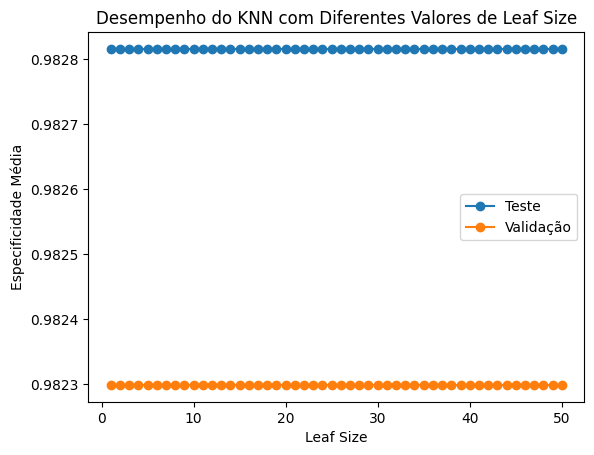

In [47]:
plt.plot(leaf_size_list, specificity_means_test, marker='o', label='Teste')
plt.plot(leaf_size_list, specificity_means_val, marker='o', label='Validação')
plt.xlabel('Leaf Size')
plt.ylabel('Especificidade Média')
plt.title('Desempenho do KNN com Diferentes Valores de Leaf Size')
plt.legend()
plt.show()

In [64]:
p_values = [1, 2]

specificity_means_test = []
specificity_means_val = []

best_p = None
best_specificity_mean_test = 0
best_specificity_mean_val = 0
best_y_test_pred = None
best_y_val_pred = None

for p in p_values:
    knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', leaf_size=1, p=p)
    knn.fit(X_train, y_train)

    y_val_pred = knn.predict(X_val)

    y_test_pred = knn.predict(X_test)

    cm_test = confusion_matrix(y_test, y_test_pred)
    specificities_test = []
    for i in range(len(cm_test)):
        TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
        FP = np.sum(cm_test[:, i]) - cm_test[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_test.append(specificity)

    specificity_mean_test = np.mean(specificities_test)
    specificity_means_test.append(specificity_mean_test)

    cm_val = confusion_matrix(y_val, y_val_pred)
    specificities_val = []
    for i in range(len(cm_val)):
        TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
        FP = np.sum(cm_val[:, i]) - cm_val[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities_val.append(specificity)

    specificity_mean_val = np.mean(specificities_val)
    specificity_means_val.append(specificity_mean_val)

    if specificity_mean_test > best_specificity_mean_test:
        best_specificity_mean_test = specificity_mean_test
        best_specificity_mean_val = specificity_mean_val
        best_p = p
        best_y_test_pred = y_test_pred
        best_y_val_pred = y_val_pred

print(f"Melhor valor de p encontrado: {best_p}")

print("\nRelatório de Classificação - Teste (Melhor Modelo)")
print(classification_report(y_test, best_y_test_pred))

print("\nRelatório de Classificação - Validação (Melhor Modelo)")
print(classification_report(y_val, best_y_val_pred))

print(f"Especificidade Média do Melhor Modelo no Teste: {best_specificity_mean_test:.4f}")
print(f"Especificidade Média do Melhor Modelo na Validação: {best_specificity_mean_val:.4f}")


Melhor valor de p encontrado: 1

Relatório de Classificação - Teste (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9012
         1.0       0.82      0.73      0.77       289
         2.0       0.95      0.93      0.94       754
         3.0       0.82      0.81      0.81        78
         4.0       0.99      0.98      0.99       813

    accuracy                           0.98     10946
   macro avg       0.91      0.89      0.90     10946
weighted avg       0.98      0.98      0.98     10946


Relatório de Classificação - Validação (Melhor Modelo)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9106
         1.0       0.85      0.75      0.80       267
         2.0       0.93      0.92      0.92       694
         3.0       0.67      0.61      0.64        84
         4.0       0.98      0.97      0.98       795

    accuracy                           0.98  

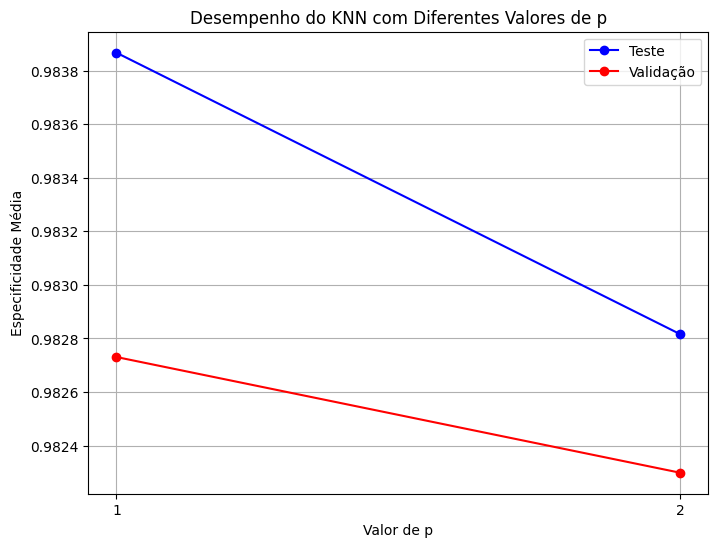

In [65]:
p_values = [1, 2]

plt.figure(figsize=(8, 6))
plt.plot(p_values, specificity_means_test, marker='o', label='Teste', color='blue')
plt.plot(p_values, specificity_means_val, marker='o', label='Validação', color='red')
plt.xlabel('Valor de p')
plt.ylabel('Especificidade Média')
plt.title('Desempenho do KNN com Diferentes Valores de p')
plt.xticks(p_values)
plt.legend()
plt.grid(True)
plt.show()

# Final:


In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

knn = KNeighborsClassifier()  # Usando o KNN com parâmetros padrão
knn.fit(X_train_scaled, y_train)

y_val_pred = knn.predict(X_val_scaled)
classification_report_val = classification_report(y_val, y_val_pred, output_dict=True)

y_test_pred = knn.predict(X_test_scaled)
classification_report_test = classification_report(y_test, y_test_pred, output_dict=True)

print("Relatório de Classificação - Validação (KNN)")
print(classification_report(y_val, y_val_pred))

print("Relatório de Classificação - Teste (KNN)")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
specificities_test = []
for i in range(len(cm_test)):
    TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
    FP = np.sum(cm_test[:, i]) - cm_test[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_test.append(specificity)

specificity_mean_test = np.mean(specificities_test)
print(f"Especificidade Média do KNN (Teste): {specificity_mean_test:.4f}")

cm_val = confusion_matrix(y_val, y_val_pred)
specificities_val = []
for i in range(len(cm_val)):
    TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
    FP = np.sum(cm_val[:, i]) - cm_val[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_val.append(specificity)

specificity_mean_val = np.mean(specificities_val)
print(f"Especificidade Média do KNN (Validação): {specificity_mean_val:.4f}")


Relatório de Classificação - Validação (KNN)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9106
         1.0       0.88      0.66      0.75       267
         2.0       0.91      0.89      0.90       694
         3.0       0.73      0.58      0.65        84
         4.0       0.99      0.95      0.97       795

    accuracy                           0.97     10946
   macro avg       0.90      0.82      0.85     10946
weighted avg       0.97      0.97      0.97     10946

Relatório de Classificação - Teste (KNN)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9012
         1.0       0.90      0.62      0.74       289
         2.0       0.95      0.89      0.92       754
         3.0       0.80      0.71      0.75        78
         4.0       1.00      0.96      0.98       813

    accuracy                           0.97     10946
   macro avg       0.93      0.83      0.87  

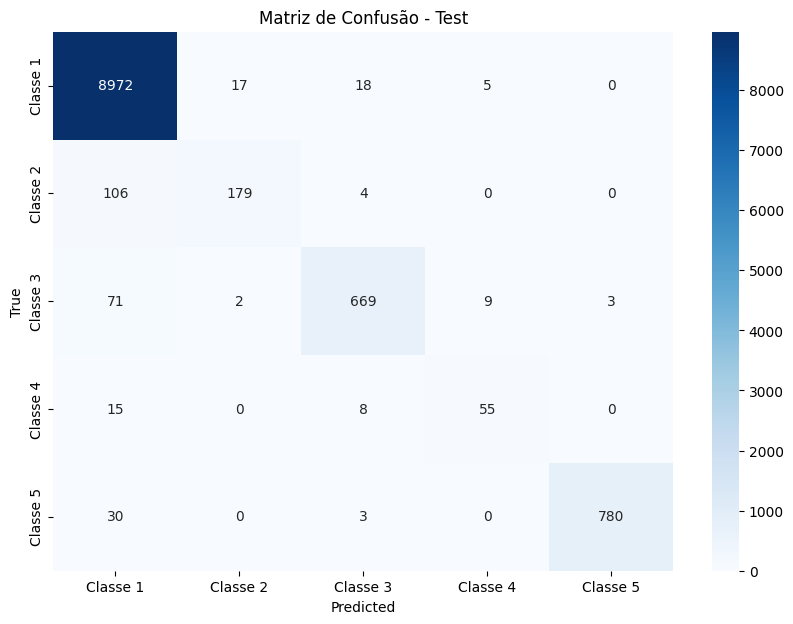

In [57]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão - Test')
plt.show()

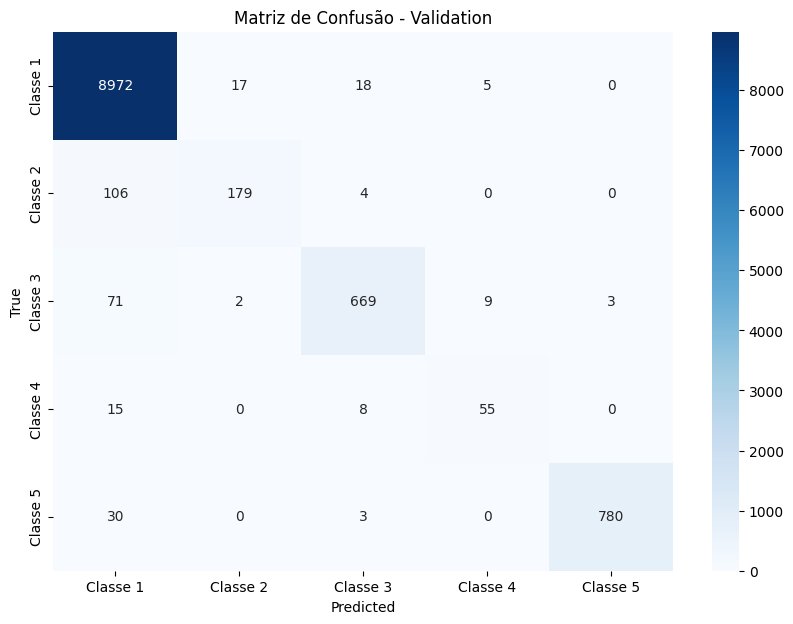

In [58]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão - Validation')
plt.show()

In [66]:
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', leaf_size=1, p=1)

knn.fit(X_train, y_train)

y_val_pred = knn.predict(X_val)

y_test_pred = knn.predict(X_test)

cm_test = confusion_matrix(y_test, y_test_pred)
specificities_test = []
for i in range(len(cm_test)):
    TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
    FP = np.sum(cm_test[:, i]) - cm_test[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_test.append(specificity)

specificity_mean_test = np.mean(specificities_test)

cm_val = confusion_matrix(y_val, y_val_pred)
specificities_val = []
for i in range(len(cm_val)):
    TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
    FP = np.sum(cm_val[:, i]) - cm_val[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_val.append(specificity)

specificity_mean_val = np.mean(specificities_val)

print("\nRelatório de Classificação - Teste")
print(classification_report(y_test, y_test_pred))

print("\nRelatório de Classificação - Validação")
print(classification_report(y_val, y_val_pred))

print(f"Especificidade Média no Teste: {specificity_mean_test:.4f}")
print(f"Especificidade Média na Validação: {specificity_mean_val:.4f}")



Relatório de Classificação - Teste
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9012
         1.0       0.82      0.73      0.77       289
         2.0       0.95      0.93      0.94       754
         3.0       0.82      0.81      0.81        78
         4.0       0.99      0.98      0.99       813

    accuracy                           0.98     10946
   macro avg       0.91      0.89      0.90     10946
weighted avg       0.98      0.98      0.98     10946


Relatório de Classificação - Validação
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9106
         1.0       0.85      0.75      0.80       267
         2.0       0.93      0.92      0.92       694
         3.0       0.67      0.61      0.64        84
         4.0       0.98      0.97      0.98       795

    accuracy                           0.98     10946
   macro avg       0.88      0.85      0.86     10946
w

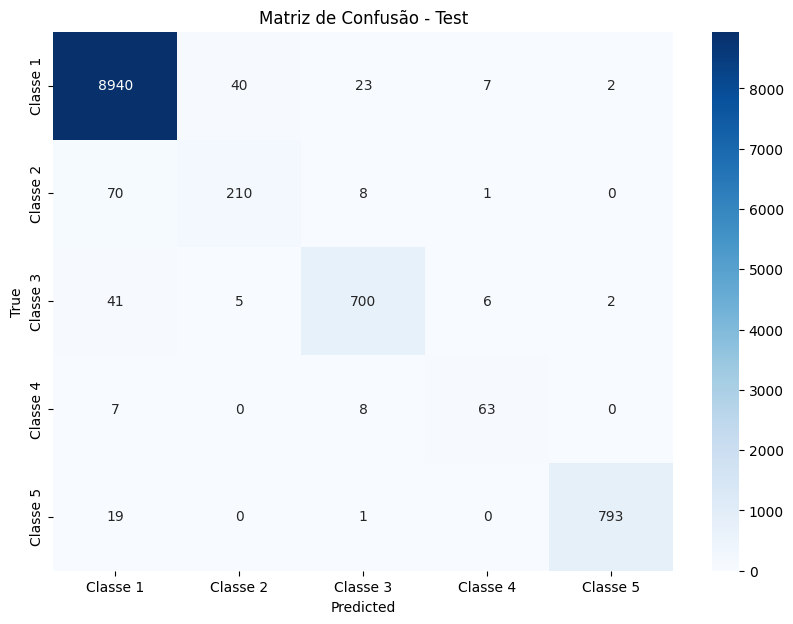

In [67]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão - Test')
plt.show()

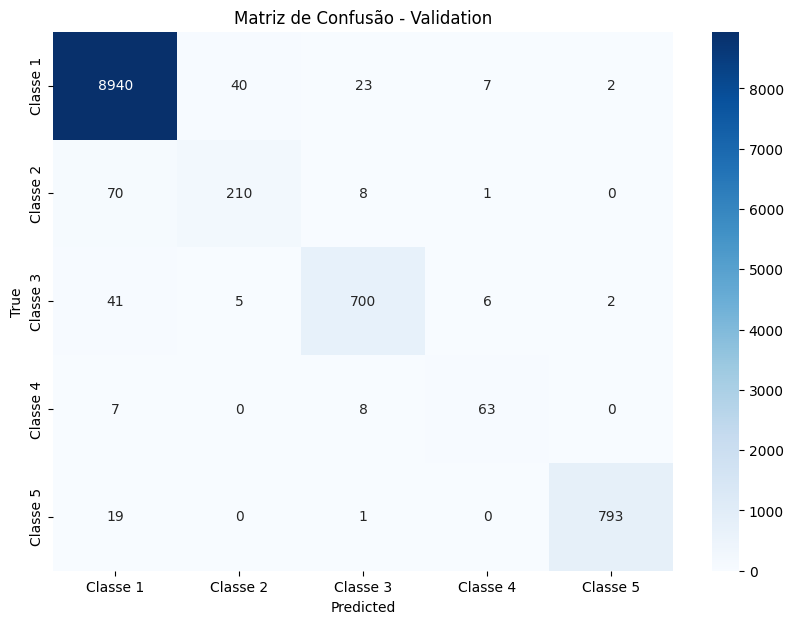

In [68]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão - Validation')
plt.show()

In [70]:
joblib.dump(knn, 'knn.joblib')

['knn.joblib']